In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import random

## Creating and training model

# Train and Test data

In [3]:
# train
trainDataRaw = pd.read_csv('../../../datasets/fraudTrain.csv')
print(trainDataRaw.shape)
print(trainDataRaw.head())

(1296675, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suit

In [6]:
# test
testDataRaw = pd.read_csv('../../../datasets/fraudTest.csv')
print(testDataRaw.shape)
print(testDataRaw.head())

(555719, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Union  

# Visualizing Data

In [232]:
print(trainDataRaw['is_fraud'].value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


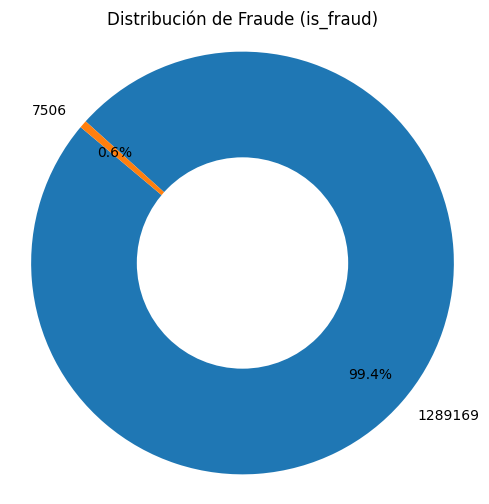

In [229]:
piecito = trainDataRaw['is_fraud'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(piecito, labels=piecito, autopct='%1.1f%%', pctdistance=0.8 , startangle=140)

cir = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(cir)

plt.title('Distribución de Fraude (is_fraud)')
plt.axis('equal') 

plt.show()


# Selección de variables 

# Feature Importance (RandomForest)

In [4]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [12]:
Xforest = trainDataRaw  # Variables independientes

In [ ]:
# 51 'state' que se repiten

In [13]:
# Date encoding
Xforest['hour'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.hour
Xforest['day'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.day_of_week
Xforest['month'] = pd.to_datetime(Xforest['trans_date_trans_time']).dt.month

In [14]:
column = ['Unnamed: 0', 'trans_date_trans_time', 'state', 'cc_num', 'merchant', 'first', 'last', 'gender', 'city', 'job', 'street', 'zip', 'dob', 'trans_num', 'unix_time', 'is_fraud']
Xforest = Xforest.drop(columns=column)

In [15]:
# Category and State one-hot encoding
Xforest = pd.get_dummies(Xforest, columns=['category'], prefix='cat')

In [16]:
Xforest.head()

,amt,lat,long,city_pop,merch_lat,merch_long,hour,day,month,cat_entertainment,...,cat_grocery_pos,cat_health_fitness,cat_home,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0,1,1,False,...,False,False,False,False,True,False,False,False,False,False
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0,1,1,False,...,True,False,False,False,False,False,False,False,False,False
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0,1,1,True,...,False,False,False,False,False,False,False,False,False,False
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0,1,1,False,...,False,False,False,False,False,False,False,False,False,False
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0,1,1,False,...,False,False,False,False,False,True,False,False,False,False


In [17]:
Xforest.shape

(1296675, 23)

In [18]:
yforest = trainDataRaw['is_fraud']  # Variable objetivo

In [19]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)

In [20]:
forest.fit(Xforest, yforest)

RandomForestClassifier(random_state=0)

In [21]:
best_ftr = forest.feature_importances_

In [22]:
# Crea un DataFrame para visualizar las importancias
best_ftr_df = pd.DataFrame({'Feature': Xforest.columns, 'Importance': best_ftr})

# Ordena las características por importancia
best_ftr_df = best_ftr_df.sort_values(by='Importance', ascending=False)


In [30]:
best_ftr_df

,Feature,Importance
0,amt,0.480311
6,hour,0.083918
13,cat_grocery_pos,0.072647
5,merch_long,0.052186
4,merch_lat,0.051333
3,city_pop,0.047727
1,lat,0.043440
2,long,0.043335
8,month,0.024749
11,cat_gas_transport,0.022781


# Correlation 

In [33]:
Xcorr= trainDataRaw

In [34]:
Xcorr.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1,1
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1,1
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1,1


In [35]:
# Date encoding
Xcorr['hour'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.hour
Xcorr['day'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.day_of_week
Xcorr['month'] = pd.to_datetime(Xcorr['trans_date_trans_time']).dt.month

In [36]:
column = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'gender', 'state', 'city', 'job', 'street', 'zip', 'dob', 'trans_num', 'unix_time']
Xcorr = Xcorr.drop(columns=column)

In [37]:
# Category one-hot encoding
Xcorr = pd.get_dummies(Xcorr, columns=['category'], drop_first=True)

In [38]:
Xcorr.head()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,hour,day,month,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0,0,1,1,...,False,False,False,False,True,False,False,False,False,False
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0,0,1,1,...,True,False,False,False,False,False,False,False,False,False
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0,0,1,1,...,False,False,False,False,False,True,False,False,False,False


In [39]:
corre_fraud = Xcorr.corrwith(Xcorr['is_fraud'])

corre_fraud = corre_fraud.abs().sort_values(ascending=False)

In [ ]:
print(corre_fraud)

is_fraud                   1.000000
amt                        0.219404
category_shopping_net      0.044261
category_grocery_pos       0.035558
category_misc_net          0.025886
category_home              0.017848
category_food_dining       0.015025
category_kids_pets         0.014967
category_health_fitness    0.014885
hour                       0.013799
month                      0.012409
category_personal_care     0.012167
category_misc_pos          0.008937
category_grocery_net       0.007136
category_travel            0.006924
category_shopping_pos      0.005955
category_gas_transport     0.004851
city_pop                   0.002136
lat                        0.001894
merch_lat                  0.001741
day                        0.001739
merch_long                 0.001721
long                       0.001721
dtype: float64


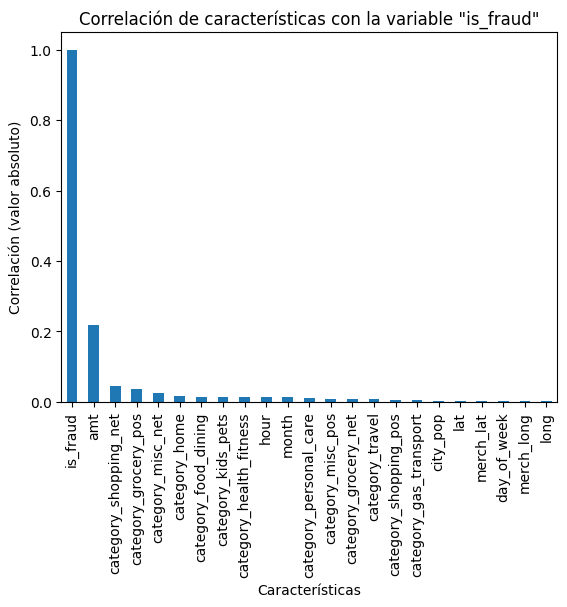

In [50]:
corre_fraud.plot(kind='bar')

plt.title('Correlación de características con la variable "is_fraud"')
plt.xlabel('Características')
plt.ylabel('Correlación (valor absoluto)')
plt.show()

# Data cleaning (trainData)

In [4]:
columns_out = ['Unnamed: 0', 'cc_num', 'merchant', 'state', 'first', 'last', 'gender', 'street', 'city', 'zip', 'city', 'job', 'dob', 'trans_num', 'unix_time']

In [7]:
trainData = trainDataRaw.drop(columns=columns_out)
testData = testDataRaw.drop(columns=columns_out)

In [8]:
# Oversampling
minorClass = trainData[trainData['is_fraud'] == 1]
trainData = pd.concat([trainData, minorClass], ignore_index=True)

In [9]:
# Undersampling
majorClass = trainData[trainData['is_fraud'] == 0]
n = len(majorClass)
majority_class_sampled = majorClass.sample(n=n, random_state=42)

In [11]:
print(trainData.shape)
trainData.head()

(1304181, 9)


,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,misc_net,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,0
1,2019-01-01 00:00:44,grocery_pos,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0
2,2019-01-01 00:00:51,entertainment,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,0
3,2019-01-01 00:01:16,gas_transport,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,0
4,2019-01-01 00:03:06,misc_pos,41.96,38.4207,-79.4629,99,38.674999,-78.632459,0


In [12]:
# Category encoding
Xtrain = pd.get_dummies(trainData, columns=['category'], prefix='cat')
Xtrain = Xtrain.drop(columns=['is_fraud'])
# Date encoding
Xtrain['hour'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.hour
Xtrain['day'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.day_of_week
Xtrain['month'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.month
Xtrain = Xtrain.drop(columns=['trans_date_trans_time'])
print(Xtrain.shape)

(1304181, 23)


In [13]:
Xtrain.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,False,False,False,False,...,False,True,False,False,False,False,False,0,1,1
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,False,False,False,False,...,False,False,False,False,False,False,False,0,1,1
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,True,False,False,False,...,False,False,False,False,False,False,False,0,1,1
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,False,False,True,False,...,False,False,False,False,False,False,False,0,1,1
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,False,False,False,False,...,False,False,True,False,False,False,False,0,1,1


In [14]:
ytrain = trainData['is_fraud']
print(ytrain.head())
print(ytrain.shape)

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64
(1304181,)


In [15]:
# New samples
smote = SMOTE(sampling_strategy='auto', random_state=42)
Xtrain, ytrain = smote.fit_resample(Xtrain, ytrain)

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# Training the model (trainData)

In [246]:
X, Xtest, y, ytest = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=42, stratify=ytrain)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

In [247]:
# Modelo feed-forward
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# X.shape[1] = 23

In [248]:
# Learning rate for RMSprop
lr = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

In [249]:
# Compile
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                768       
                                                                 
 dense_26 (Dense)            (None, 64)                2112      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [250]:
# Ajustando el peso de clases minoritarias
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)


In [251]:
# Train 
model.fit(X, y, epochs=8, batch_size=32, validation_data=(Xtest, ytest), class_weight=dict(enumerate(class_weights)))
model.save('detectorV2.h5')

Epoch 1/8
60430/60430 [==============================] - 101s 2ms/step - loss: 0.1251 - accuracy: 0.9521 - val_loss: 0.0839 - val_accuracy: 0.9674
Epoch 2/8
60430/60430 [==============================] - 100s 2ms/step - loss: 0.0824 - accuracy: 0.9675 - val_loss: 0.0803 - val_accuracy: 0.9679
Epoch 3/8
60430/60430 [==============================] - 96s 2ms/step - loss: 0.0805 - accuracy: 0.9683 - val_loss: 0.0795 - val_accuracy: 0.9677
Epoch 4/8
60430/60430 [==============================] - 104s 2ms/step - loss: 0.0789 - accuracy: 0.9684 - val_loss: 0.0813 - val_accuracy: 0.9682
Epoch 5/8
60430/60430 [==============================] - 97s 2ms/step - loss: 0.0798 - accuracy: 0.9691 - val_loss: 0.0828 - val_accuracy: 0.9687
Epoch 6/8
60430/60430 [==============================] - 122s 2ms/step - loss: 0.0823 - accuracy: 0.9694 - val_loss: 0.1064 - val_accuracy: 0.9634
Epoch 7/8
60430/60430 [==============================] - 105s 2ms/step - loss: 0.0857 - accuracy: 0.9692 - val_loss: 0.1

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [252]:
# Evaluate the model
predict = model.predict(Xtest)

20144/20144 [==============================] - 18s 892us/step


In [253]:
predict = (predict > 0.5) # if prob > 0.5 is fraud and vice versa

In [255]:
# Confusion matrix 
confusion = confusion_matrix(ytest, predict)
print("Confusion Matrix:")
print(confusion)
# Correct 0 - Incorrect 1
# Incorrect 0 - Correct 1

Confusion Matrix:
[[314225   8068]
 [ 11610 310682]]


In [256]:
# Classification report
report = classification_report(ytest, predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    322293
           1       0.97      0.96      0.97    322292

    accuracy                           0.97    644585
   macro avg       0.97      0.97      0.97    644585
weighted avg       0.97      0.97      0.97    644585



# Model Checking

In [257]:
print(testDataRaw.shape)
print(testData.shape)

(555719, 23)
(555719, 9)


In [258]:
# Category encoding
XtestCheck = pd.get_dummies(testData, columns=['category'], prefix=['cat'])
XtestCheck = XtestCheck.drop(columns=['is_fraud'])
# Date encoding
XtestCheck['hour'] = pd.to_datetime(testData['trans_date_trans_time']).dt.hour
XtestCheck['day'] = pd.to_datetime(testData['trans_date_trans_time']).dt.day_of_week
XtestCheck['month'] = pd.to_datetime(testData['trans_date_trans_time']).dt.month
XtestCheck = XtestCheck.drop(columns=['trans_date_trans_time'])
print(XtestCheck.shape)

(555719, 23)


In [259]:
XtestCheck.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
1,29.84,40.3207,-110.4360,302,39.450498,-109.960431,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
2,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,False,False,False,False,...,False,False,False,False,False,False,False,12,6,6
3,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,False,False,False,False,...,False,False,True,False,False,False,False,12,6,6
4,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,False,False,False,False,...,False,False,False,False,False,False,True,12,6,6


In [260]:
scaler = StandardScaler()
XtestCheck = scaler.fit_transform(XtestCheck)
XtestCheck = scaler.transform(XtestCheck)

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [261]:
XtestCheck.shape

(555719, 23)

In [262]:
loaded_model = tf.keras.models.load_model("detectorV2.h5")
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                768       
                                                                 
 dense_26 (Dense)            (None, 64)                2112      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [263]:
predict = loaded_model.predict(XtestCheck)

17367/17367 [==============================] - 15s 888us/step


In [272]:
predicted = (predict > 0.5).astype(float)

In [278]:
testData['predicted'] = predicted
testData

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,predicted
0,2020-06-21 12:14:25,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0,0.0
1,2020-06-21 12:14:33,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0,0.0
2,2020-06-21 12:14:53,health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0,0.0
3,2020-06-21 12:15:15,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0,1.0
4,2020-06-21 12:15:17,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0,1.0
...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,health_fitness,43.77,40.4931,-91.8912,519,39.946837,-91.333331,0,0.0
555715,2020-12-31 23:59:09,kids_pets,111.84,29.0393,-95.4401,28739,29.661049,-96.186633,0,1.0
555716,2020-12-31 23:59:15,kids_pets,86.88,46.1966,-118.9017,3684,46.658340,-119.715054,0,1.0
555717,2020-12-31 23:59:24,travel,7.99,44.6255,-116.4493,129,44.470525,-117.080888,0,1.0


In [285]:
fraudRows = testData[(testData['is_fraud'] == 1) & (testData['predicted'] == 1.0)]
print(fraudRows)

       trans_date_trans_time       category     amt      lat      long  \
1767     2020-06-21 22:32:22       misc_net  780.52  42.5545  -90.3508   
1781     2020-06-21 22:37:27  entertainment  620.33  42.5545  -90.3508   
2039     2020-06-22 00:06:40       misc_net  701.81  30.4590  -90.9027   
2173     2020-06-22 01:18:02       misc_pos    8.39  27.6330  -80.4031   
2195     2020-06-22 01:25:13    grocery_pos  326.94  30.4590  -90.9027   
...                      ...            ...     ...      ...       ...   
505711   2020-12-21 02:02:00    grocery_pos  349.96  48.2777 -112.8456   
505774   2020-12-21 02:21:41    grocery_pos  358.24  48.2777 -112.8456   
511272   2020-12-21 22:42:11    food_dining  123.58  48.2777 -112.8456   
517529   2020-12-22 23:06:03    grocery_pos  289.27  34.6323  -89.8855   
517571   2020-12-22 23:13:39       misc_net  766.38  34.6323  -89.8855   

        city_pop  merch_lat  merch_long  is_fraud  predicted  
1767        1306  42.461127  -91.147148         